# Exercise 5 - Solution
***

<div class=obj>
    <b>Aim:</b> To find the best fitting Euler pole of rotation between South American and Africa, based on the geometry of the fracture zones.
</div>

<p></p>



In [1]:
import pandas as pd
import numpy as np
import cartopy as ctp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy.optimize as optm

#let's start by reading in the ridges so we have these available later for plotting
# we are not going to use the ridges in the inversion to find the plate pole
dr = pd.read_csv('data/gale_ridge_segs.csv',header=0, index_col=None)
#we should now restrict the ridges to those in the geographical region we are interested in
# note, that I am resetting the index to 0 here, else Pandas creates a new dataframe keeping
# the indices of the old row locations
lonmin, lonmax, latmin, latmax = -60., -5., -6., 20.
dr = dr[(dr.Lat1<latmax) & (dr.Lat1>latmin) & (dr.Lat2<latmax) & (dr.Lat2>latmin) &\
        (dr.Lon1<lonmax) & (dr.Lon1>lonmin) & (dr.Lon2<lonmax) & (dr.Lon2>lonmin)].reset_index()

#now we can readin fracture zones
df = pd.read_csv('data/fracture_zones.csv',header=0, index_col=0)

#------------- This code creates the fracture zone file from the rige segs ---------#
#                 You can just read the ridge fracture zone file directly           #
stop = len(dr.Lat2)

lon1, lon2, lat1, lat2 = np.zeros(stop-1), np.zeros(stop-1), np.zeros(stop-1),np.zeros(stop-1)
for i, d in enumerate(dr.iterrows()):
    if i<stop-1 :
        lon1[i], lon2[i], lat1[i], lat2[i] = d[1].Lon2, dr.Lon1[i+1], d[1].Lat2, dr.Lat1[i+1]
        
transforms = pd.DataFrame(np.vstack([lon1, lat1, lon2, lat2]).transpose())
transforms.columns = ['lon1', 'lat1', 'lon2', 'lat2']
transforms.to_csv('data/fracture_zones.csv')
#-----------------------------------------------------------------------------------#

#we need our oblique mercator projection code
def obq_mc(point, pole, center):
    #critically, we need to remember a degrees to radians conversion
    pnt = np.deg2rad(point)
    ple = np.deg2rad(pole)
    cnt = np.deg2rad(center)

    x = np.zeros(point.shape[0])
    y = np.zeros(point.shape[0])
    for i in range(point.shape[0]):
        A = np.sin(ple[0])*np.sin(pnt[i,0]) - np.cos(ple[0])*np.cos(pnt[i,0])*np.sin(pnt[i,1]-cnt)

        x[i] = np.arctan((np.tan(pnt[i,0])*np.cos(ple[0]) + np.sin(ple[0])*np.sin(pnt[i,1]-cnt))/
                         np.cos(pnt[i,1]-cnt))
        y[i] = 0.5 * np.log((1+A)/(1-A))

    return x, y

#now we set up our misfit function
# it is expecting a dataframe with .lat1, .lat2, .lon1, and .lon2
# a minimum (i.e., best fit pole) is when each pair of y values is identical
def misfit(pole, df):
    #this needs to be defined for the oblique projection: a center 90deg
    # away from the pole
    center = pole[1]+90

    #now, perform the transformation on the start and ends of each transform fault
    x1, y1 = obq_mc(np.vstack([df.lat1, df.lon1]).transpose(), pole, center)
    x2, y2 = obq_mc(np.vstack([df.lat2, df.lon2]).transpose(), pole, center)

    #combine the output y-coordinates as these are what gets compared for misfit
    ys = np.vstack([y1, y2]).transpose()

    msf = np.sqrt( np.sum((ys[:,0]-ys[:,1])**2) / ys.shape[0] )
    #return the root mean squared misfit
    return msf

First, let's test our oblique Mercator function.

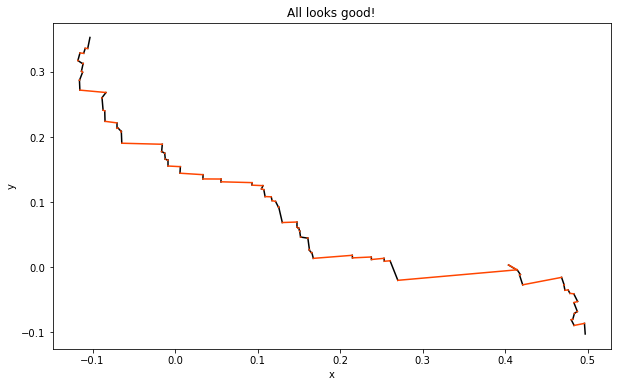

In [9]:
#plot results
pole=[90,50]

# first calculate preferred projected coordinates
x1f, y1f = obq_mc(np.vstack([df.lat1, df.lon1]).transpose(), pole, pole[1]+90)
x2f, y2f = obq_mc(np.vstack([df.lat2, df.lon2]).transpose(), pole, pole[1]+90)

x1r, y1r = obq_mc(np.vstack([dr.Lat1, dr.Lon1]).transpose(), pole, pole[1]+90)
x2r, y2r = obq_mc(np.vstack([dr.Lat2, dr.Lon2]).transpose(), pole, pole[1]+90)

fg, ax = plt.subplots(1, figsize=(10,6))
#now we want to pair each x1y1 with x1y2 to plot the segments
# first for the ridges
for i in range(len(x1r)):
    ax.plot([x1r[i], x2r[i]], [y1r[i], y2r[i]], linestyle='-', color='black')

# now for the fracture zones
for i in range(len(x1f)):
    ax.plot([x1f[i], x2f[i]], [y1f[i], y2f[i]], linestyle='-', color='orangered')

#it isn't often you get to label x and y axes with x and y, so take the opportunity!
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('All looks good!');

     fun: 0.001719724595620392
 message: ['Maximum number of iteration reached']
    nfev: 4073
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([ 66.56766337, -35.93909516])
DeMets 1994 pole [ 62.5 -39.4] with a fracture zone misfit of 0.0022046800825710885
Our best fit pole ['66.57', '-35.94'] with a fracture zone misfit 0.001719724595620392


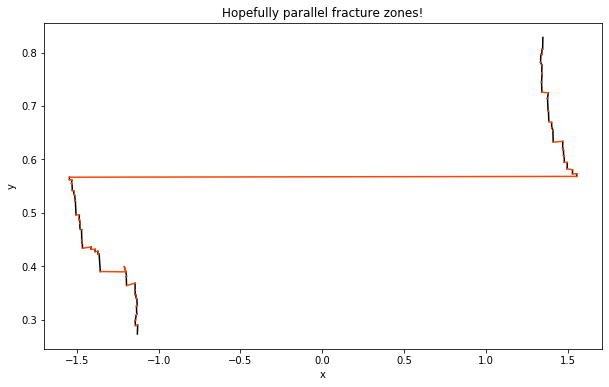

In [6]:
pole = np.array([62.5, -39.4])
pole = np.array([90., 0.])
pole_guess = np.array([80, -20])

res = optm.dual_annealing(misfit, bounds=list(zip([0, -180],[90, 180])), args=[df])
print(res)

pole = np.array([62.5, -39.4])
print('DeMets 1994 pole', pole, 'with a fracture zone misfit of', misfit(pole, df))

pole = res.x
print('Our best fit pole', ['{:.2f}'.format(p) for p in pole], 'with a fracture zone misfit', misfit(pole, df))

#plot results
# first calculate preferred projected coordinates
x1f, y1f = obq_mc(np.vstack([df.lat1, df.lon1]).transpose(), pole, pole[1]+90)
x2f, y2f = obq_mc(np.vstack([df.lat2, df.lon2]).transpose(), pole, pole[1]+90)

x1r, y1r = obq_mc(np.vstack([dr.Lat1, dr.Lon1]).transpose(), pole, pole[1]+90)
x2r, y2r = obq_mc(np.vstack([dr.Lat2, dr.Lon2]).transpose(), pole, pole[1]+90)

fg, ax = plt.subplots(1, figsize=(10,6))
#now we want to pair each x1y1 with x1y2 to plot the segments
# first for the ridges
for i in range(len(x1r)):
    ax.plot([x1r[i], x2r[i]], [y1r[i], y2r[i]], linestyle='-', color='black')

# now for the fracture zones
for i in range(len(x1f)):
    ax.plot([x1f[i], x2f[i]], [y1f[i], y2f[i]], linestyle='-', color='orangered')
    
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('Hopefully parallel fracture zones!');

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open(".styles/custom.css", "r").read()
    return HTML(styles)
css_styling()